## Build model of movie watchers and movies:

Lets see how collaborative filtering can be used to create a model of movies and imdb users using fastai. We further show the results using dimensional reduction and further apply clustering to extract movie genres. We do this without explicit reference to movie labels.

In [176]:
# Import the required libraries
import pandas as pd # Pandas deals with handling data. 
import numpy as np # Numpy provides a lot of FAST ways for array manipulation in python.
import matplotlib.pyplot as plt # Plotting script library
import matplotlib as mpl # Plotting
import seaborn as sns # More plotting

%matplotlib inline 
# Define some plotting params:
mpl.rcParams['figure.figsize'] = (12,6)
sns.set_style("whitegrid", {"axes.facecolor": ".99"})

### Start by importing sample of imdb movie dataset using fastai.

In [178]:
from fastai.collab import untar_data, URLs

path = untar_data(URLs.ML_100k)
print('The data is here: ', path)

ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])

# The file has weird encoding but pandas provides a way of changing it.
items = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', header=None, 
                    names=['movie', 'title', 'release date', 'video release date', 'IMDb URL', 
                           'unknown', 'Action', 'Adventure', 'Animation', "Children's", 
                           'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                           'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

ratings.head()

The data is here:  /home/topi/.fastai/data/ml-100k


,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [179]:
df = pd.merge(ratings, items, on='movie').drop(columns=['timestamp'])
df.sort_values('user').head(10)

,user,movie,rating,title,release date,video release date,IMDb URL,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
43606,1,12,5,"Usual Suspects, The (1995)",14-Aug-1995,NaN,"http://us.imdb.com/M/title-exact?Usual%20Suspects,%20The%20(1995)",0,0,0,...,0,0,0,0,0,0,0,1,0,0
79998,1,254,1,Batman & Robin (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?Batman+%26+Robin+(1997),0,1,1,...,0,0,0,0,0,0,0,0,0,0
35906,1,189,3,"Grand Day Out, A (1992)",01-Jan-1992,NaN,"http://us.imdb.com/M/title-exact?Grand%20Day%20Out,%20A%20(1992)",0,0,0,...,0,0,0,0,0,0,0,0,0,0
69127,1,87,5,Searching for Bobby Fischer (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Searching%20for%20Bobby%20Fischer%20(1993),0,0,0,...,0,0,0,0,0,0,0,0,0,0
51383,1,187,4,"Godfather: Part II, The (1974)",01-Jan-1974,NaN,"http://us.imdb.com/M/title-exact?Godfather:%20Part%20II,%20The%20(1974)",0,1,0,...,0,0,0,0,0,0,0,0,0,0
71026,1,180,3,Apocalypse Now (1979),01-Jan-1979,NaN,http://us.imdb.com/M/title-exact?Apocalypse%20Now%20(1979),0,0,0,...,0,0,0,0,0,0,0,0,1,0
97387,1,46,4,Exotica (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Exotica%20(1994),0,0,0,...,0,0,0,0,0,0,0,0,0,0
6611,1,201,3,Evil Dead II (1987),01-Jan-1987,NaN,http://us.imdb.com/M/title-exact?Evil%20Dead%20II%20(1987),0,1,1,...,0,0,1,0,0,0,0,0,0,0
36126,1,64,5,"Shawshank Redemption, The (1994)",01-Jan-1994,NaN,"http://us.imdb.com/M/title-exact?Shawshank%20Redemption,%20The%20(1994)",0,0,0,...,0,0,0,0,0,0,0,0,0,0
6751,1,241,4,"Last of the Mohicans, The (1992)",01-Jan-1992,NaN,"http://us.imdb.com/M/title-exact?Last%20of%20the%20Mohicans,%20The%20(1992)",0,1,0,...,0,0,0,0,0,1,0,0,1,0


Each movie rated by a user is a single row in the dataframe. Then one can check how many movies each user has rated and plot a histogram:

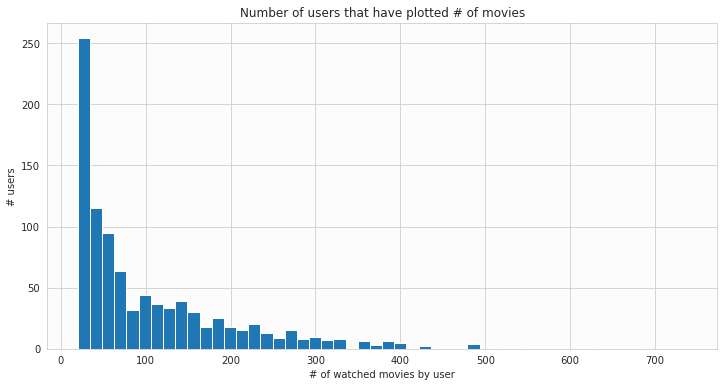

In [180]:
ax = df.loc[:, 'user'].value_counts().hist(bins=50)
ax.set_title('Number of users that have plotted # of movies')
ax.set_xlabel('# of watched movies by user')
_ = ax.set_ylabel('# users')

Similarly we can chec the most popular movies:

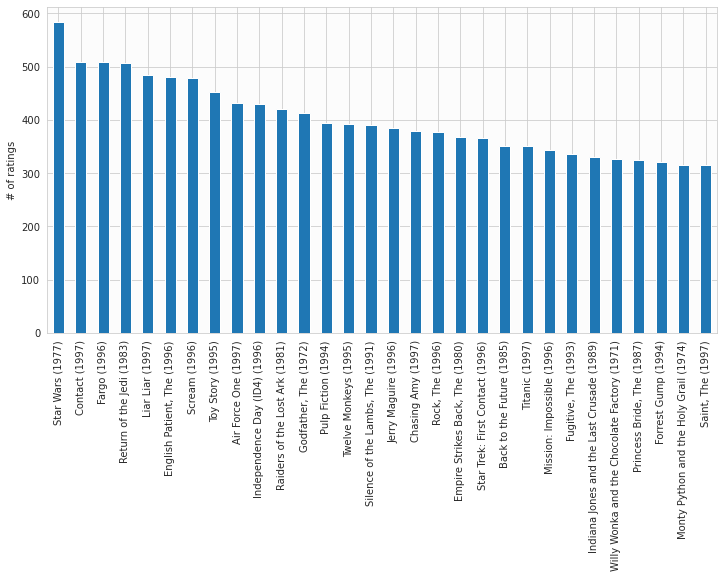

In [181]:
ax = df.loc[:, 'title'].value_counts().iloc[:30].plot.bar()
_ = ax.set_ylabel('# of ratings')

#### Lets pick the N most popular movies and M most active users:

In [182]:
nusers = 20
nmovies = 10
users = df.loc[:, 'user'].value_counts().iloc[:nusers].index
titles = df.loc[:, 'title'].value_counts().iloc[:nmovies].index
df_filtered = df.loc[df.user.isin(users) & df.title.isin(titles), :]

pd.pivot_table(df_filtered, index='user', columns='title', values='rating')

title,Air Force One (1997),Contact (1997),"English Patient, The (1996)",Fargo (1996),Independence Day (ID4) (1996),Liar Liar (1997),Return of the Jedi (1983),Scream (1996),Star Wars (1977),Toy Story (1995)
user,,,,,,,,,,
7,4.0,4.0,4.0,5.0,5.0,1.0,3.0,4.0,5.0,NaN
13,1.0,4.0,3.0,5.0,5.0,2.0,5.0,1.0,5.0,3.0
92,NaN,4.0,NaN,5.0,5.0,3.0,4.0,3.0,5.0,4.0
94,NaN,5.0,4.0,5.0,2.0,NaN,4.0,3.0,5.0,4.0
181,3.0,3.0,1.0,3.0,4.0,2.0,NaN,4.0,NaN,3.0
234,3.0,2.0,3.0,4.0,NaN,3.0,3.0,3.0,4.0,3.0
276,4.0,5.0,NaN,5.0,4.0,4.0,5.0,4.0,5.0,5.0
279,NaN,NaN,NaN,4.0,4.0,2.0,3.0,3.0,3.0,3.0
293,2.0,3.0,3.0,4.0,3.0,2.0,3.0,3.0,5.0,2.0


## Task: find a way to predict a score user would give to a movie they have not seen (i.e., fill the nans)

Let us assume that each user can be described by a set of numbers $[f_{1i}, ... f_{Ni}]$, where $f_{ji}$ is the *latent factor* $j$ of user $i$. Furthermore assume similarly that a movie can be labeled by some other latent factors $[g_{1k},\ldots,g_{Mk}]$, where $g_{jk}$ is the *latent factor* $j$ of movie $k$. 

These latent factors could be viewed as, say preferences of a single user, and some properties (like genre) of a movie. Lets consider example user $U$ that strongly prefers western movies from the 70:ies over anything else, not bad taste! Lets denote for this user:

$\mathbf{f}_U = [f_{\text{western}}, f_{\text{70:ies}}, f_\text{scifi}] = [2, 2, 0]$,

Moreover, let us label our example movie $M$ by the same latent factors. We shall further assume that the example movies is "The good, the bad, and the ugly (1966)", then, 

$\mathbf{g}_M = [g_{\text{western}}, g_{\text{70:ies}}, g_\text{scifi}] = [1, .8, 0]$.

What would be the score given by user $U$ to movie $M$? We can figure out whatever, way of combining the above numbers but the simplest one is to take the innner product:

$R_{UM} = \mathbf{f}_U \cdot \mathbf{g}_M = \sum_i f_i g_i = 2 + 1.6 + 0 = 3.6$.

Let us now assume that each number in the above pivot table is a result of such scoring given by some *latent factors* of the movies and users. Let us then use pytorch to figure out the latent factors.

### (RMS) Loss:

In [183]:
from torch import tensor, nn
import torch

def init_params(size): return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

def update_params(params, lr):
    params.data -= lr * params.grad.data
    params.grad = None

class DotProductScore():
    
    def __init__(self, users_shape, movies_shape, X, use_bias=False):
        
        self.use_bias = use_bias
        self.x = X
        
        try:
            self.load(users_shape, movies_shape)
        except FileNotFoundError as e:
            print('Not found')
            self.lat_users = init_params(users_shape)
            self.lat_movies = init_params(movies_shape)
            self.bias_users = init_params((users_shape[0], ))
            self.bias_movies = init_params((movies_shape[0], ))
        
        
    def get_loss(self):
        """
        Define a loss for your prediction. We know the true ratings given
        by users are stored in self.x[:, 2].
        """
        pred_rating = self.get_prediction(self.x[:, :2])
        return ((pred_rating - self.x[:, 2].flatten())**2).mean()
    
    def get_prediction(self, users_movies):
        """
        Use latent factors to produce a prediction of rating for given users and movies.
        """
        lat_users = self.lat_users[users_movies[:, 0]-1]
        lat_movies = self.lat_movies[users_movies[:, 1]-1]
        if self.use_bias:
            return (lat_users*lat_movies).sum(dim=1) \
                    + self.bias_movies[users_movies[:, 1]-1] \
                    + self.bias_users[users_movies[:, 0]-1]
        else:
            return (lat_users*lat_movies).sum(dim=1) 
        
    def update_lat(self, lr=.3):
        """
        Update the latend factors using learning_rate lr.
        """
        loss = self.get_loss()
        loss.backward()
        
        update_params(self.lat_users, lr)
        update_params(self.lat_movies, lr)
        if self.use_bias:
            update_params(self.bias_users, lr)
            update_params(self.bias_movies, lr)
        
        return loss
    
    def get_params(self, idxs, key='user'):
        if key=='user':
            lat = self.lat_users[idxs-1]
            bias = self.bias_users[idxs-1]
        elif key=='movie':
            lat = self.lat_movies[idxs-1]
            bias = self.bias_movies[idxs-1]
        
        if self.use_bias: return lat, bias
        else: return lat
    
    def save(self):
        torch.save(self.lat_users, 'lat_users_{}_{}_bias={}.to'.format(*self.lat_users.shape, self.use_bias))
        torch.save(self.lat_movies, 'lat_movies_{}_{}_bias={}.to'.format(*self.lat_movies.shape, self.use_bias))
        torch.save(self.bias_users, 'bias_users_{}_bias={}.to'.format(self.lat_users.shape[0], self.use_bias))
        torch.save(self.bias_movies, 'bias_movies_{}_bias={}.to'.format(self.lat_movies.shape[0], self.use_bias))

    def load(self, users_shape, movies_shape):
        self.lat_users = torch.load('lat_users_{}_{}_bias={}.to'.format(*users_shape, self.use_bias))
        self.lat_movies = torch.load('lat_movies_{}_{}_bias={}.to'.format(*movies_shape, self.use_bias))
        self.bias_users = torch.load('bias_users_{}_bias={}.to'.format(users_shape[0], self.use_bias))
        self.bias_movies = torch.load('bias_movies_{}_bias={}.to'.format(movies_shape[0], self.use_bias))
        

In [184]:
nlatent = 30
nusers = df.user.nunique()
nmovies = df.movie.nunique()

use_bias = True

X = torch.tensor(df.loc[:, ['user', 'movie', 'rating']].values)
dps = DotProductScore((nusers, nlatent), (nmovies, nlatent), X, use_bias)


for i in range(20000):
    loss = dps.update_lat()
    if i%500 == 0:
        print(i, loss.data)
        dps.save()


0 tensor(0.2451)
500 tensor(0.2442)
1000 tensor(0.2434)
1500 tensor(0.2426)
2000 tensor(0.2419)
2500 tensor(0.2411)
3000 tensor(0.2403)
3500 tensor(0.2396)
4000 tensor(0.2389)
4500 tensor(0.2381)
5000 tensor(0.2374)
5500 tensor(0.2367)
6000 tensor(0.2361)
6500 tensor(0.2354)
7000 tensor(0.2347)
7500 tensor(0.2341)
8000 tensor(0.2334)
8500 tensor(0.2328)
9000 tensor(0.2322)
9500 tensor(0.2316)
10000 tensor(0.2310)
10500 tensor(0.2304)
11000 tensor(0.2298)
11500 tensor(0.2292)
12000 tensor(0.2287)
12500 tensor(0.2281)
13000 tensor(0.2275)
13500 tensor(0.2270)
14000 tensor(0.2265)
14500 tensor(0.2259)
15000 tensor(0.2254)
15500 tensor(0.2249)
16000 tensor(0.2244)
16500 tensor(0.2239)
17000 tensor(0.2234)
17500 tensor(0.2229)
18000 tensor(0.2224)
18500 tensor(0.2220)
19000 tensor(0.2215)
19500 tensor(0.2210)


In [185]:
df.loc[:, 'user_biases'] = dps.get_params(df.user)[1].detach().numpy()
df.loc[:, 'movie_biases'] = dps.get_params(df.movie, key='movie')[1].detach().numpy()

In [186]:
movie_bias_df = df.drop_duplicates(subset=['movie']).loc[:, ['title', 'movie_biases']]
movie_bias_df.sort_values('movie_biases', ascending=False)

,title,movie_biases
31134,Schindler's List (1993),2.563435
97953,Pather Panchali (1955),2.515083
36120,"Shawshank Redemption, The (1994)",2.503904
27342,Casablanca (1942),2.493722
73644,Wallace & Gromit: The Best of Aardman Animation (1996),2.476763
...,...,...
98477,Police Story 4: Project S (Chao ji ji hua) (1993),-0.371211
75210,Children of the Corn: The Gathering (1996),-0.382636
59738,Amityville: A New Generation (1993),-0.457049
96799,Amityville 1992: It's About Time (1992),-0.468244


In [209]:
movie_title_df = df.sort_values('movie').drop_duplicates(subset=['movie']).set_index('movie')
lat_movie = dps.get_params(movie_title_df.index, key='movie')[0].detach().numpy()

In [210]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

lat_movie_pca = PCA(n_components=2).fit_transform(lat_movie)
lat_movie_tsne = TSNE(n_components=2).fit_transform(lat_movie)

In [211]:
N = 50
popular_movies = df.loc[:, 'movie'].value_counts().iloc[:N].index

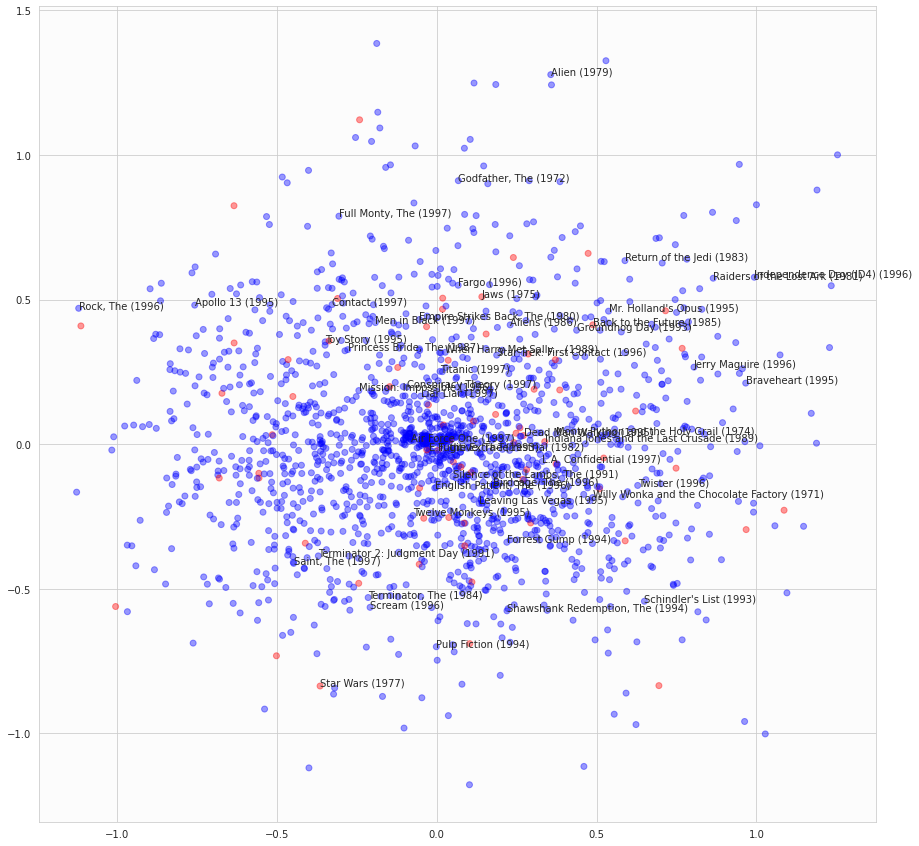

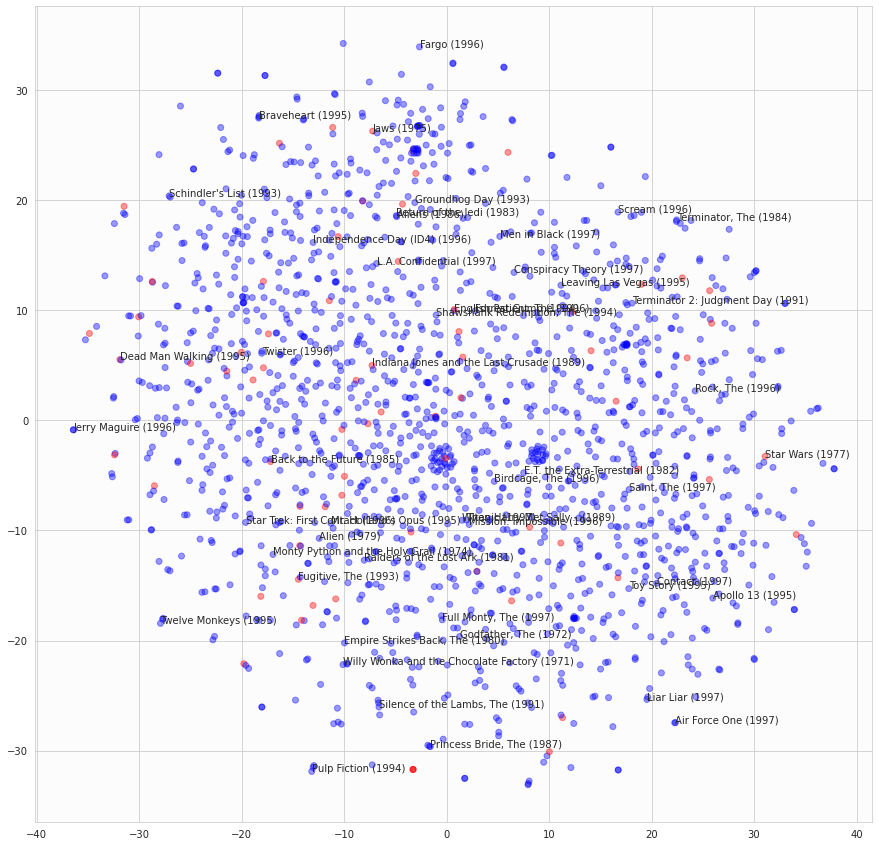

In [231]:
def plot_movies(movie_2d, idxs, popular_movies):
    
    plt.subplots(figsize=(15,15))
    
    colors = np.array(['blue']*len(idxs), dtype=object)
    colors[movie_title_df.loc[idxs, 'War'].astype(bool)] = 'red'
    
    plt.scatter(movie_2d[idxs-1, 0], movie_2d[idxs-1, 1], c=colors, alpha=.4)
    for idx in popular_movies:
        plt.annotate(movie_title_df.loc[idx, 'title'], xy=(movie_2d[idx, :]))
    plt.show()
    
plot_movies(lat_movie_pca, movie_title_df.index, popular_movies)
plot_movies(lat_movie_tsne, movie_title_df.index, popular_movies)

In [200]:
((dps.get_prediction(torch.tensor(df.loc[:, ['user', 'movie']].values)).detach().numpy() - df.loc[:, 'rating'])**2).mean()

0.22058237884280602

In [201]:
df.loc[:, 'predicted_rating'] = dps.get_prediction(torch.tensor(df.loc[:, ['user', 'movie']].values)).detach().numpy()
df

,user,movie,rating,title,release date,video release date,IMDb URL,unknown,Action,Adventure,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,user_biases,movie_biases,predicted_rating
0,196,242,3,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,2.013971,1.873061,2.621349
1,63,242,3,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,1.573706,1.873061,3.429116
2,226,242,5,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,1.636541,1.873061,4.419511
3,154,242,3,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,1.618868,1.873061,2.899617
4,306,242,5,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,2.032155,1.873061,4.905669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,840,1674,4,Mamma Roma (1962),01-Jan-1962,NaN,http://us.imdb.com/M/title-exact?Mamma%20Roma%20(1962),0,0,0,...,0,0,0,0,0,0,0,2.389255,0.577711,3.866941
99996,655,1640,3,"Eighth Day, The (1996)",01-Nov-1996,NaN,"http://us.imdb.com/Title?Huiti%E8me+jour,+Le+(1996)",0,0,0,...,0,0,0,0,0,0,0,1.512092,0.391697,2.796628
99997,655,1637,3,Girls Town (1996),23-Aug-1996,NaN,http://us.imdb.com/M/title-exact?Girls%20Town%20(1996),0,0,0,...,0,0,0,0,0,0,0,1.512092,0.394226,2.799066
99998,655,1630,3,"Silence of the Palace, The (Saimt el Qusur) (1994)",02-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Saimt%20el%20Qusur%20(1994),0,0,0,...,0,0,0,0,0,0,0,1.512092,0.382745,2.800453


In [206]:
df.drop_duplicates(subset=['user']).sort_values('user_biases')

,user,movie,rating,title,release date,video release date,IMDb URL,unknown,Action,Adventure,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,user_biases,movie_biases,predicted_rating
78,206,242,3,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0.425390,1.873061,2.762153
44,181,242,1,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0.519651,1.873061,0.975058
174,405,302,4,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Confidential+(1997),0,0,0,...,0,1,0,0,1,0,0,0.541591,2.241294,4.017462
305,865,302,5,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Confidential+(1997),0,0,0,...,0,1,0,0,1,0,0,0.551257,2.241294,4.632570
282,445,302,1,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Confidential+(1997),0,0,0,...,0,1,0,0,1,0,0,0.593635,2.241294,1.472502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,519,346,4,Jackie Brown (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-119396,0,0,0,...,0,0,0,0,0,0,0,3.317987,1.494205,4.099564
4845,928,246,5,Chasing Amy (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Chasing+Amy+(1997),0,0,0,...,0,0,1,0,0,0,0,3.324164,1.932117,4.820270
163,427,302,4,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Confidential+(1997),0,0,0,...,0,1,0,0,1,0,0,3.379433,2.241294,3.720056
210,507,302,5,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Confidential+(1997),0,0,0,...,0,1,0,0,1,0,0,3.384193,2.241294,4.670752


### Suggested exercises:
1. Modify the loss so that mis prediction on a popular title would be more serious than on a unpopular one.
2. Try to device a regularization that would push as many of the latent factors to zero as possible.

